In [ ]:
!pip install captum

In [ ]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr import Saliency, LayerGradCam, Lime

In [ ]:
model = models.resnet18(pretrained=True)
model = model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 94.4MB/s]


In [ ]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2024-05-25 00:21:06--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.195.80, 3.5.12.126, 54.231.164.56, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.195.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/root/.torch/models/imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.09s   

2024-05-25 00:21:07 (402 KB/s) - ‘/root/.torch/models/imagenet_class_index.json’ saved [35363/35363]



In [ ]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [ ]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

# img = Image.open('img/resnet/swan-3299528_1280.jpg')

from PIL import Image
import requests
from io import BytesIO

url = "https://cdn.pixabay.com/photo/2018/04/07/20/32/swan-3299528_1280.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [ ]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: black_swan ( 0.46728289127349854 )


## Gradient-based attribution

In [ ]:
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

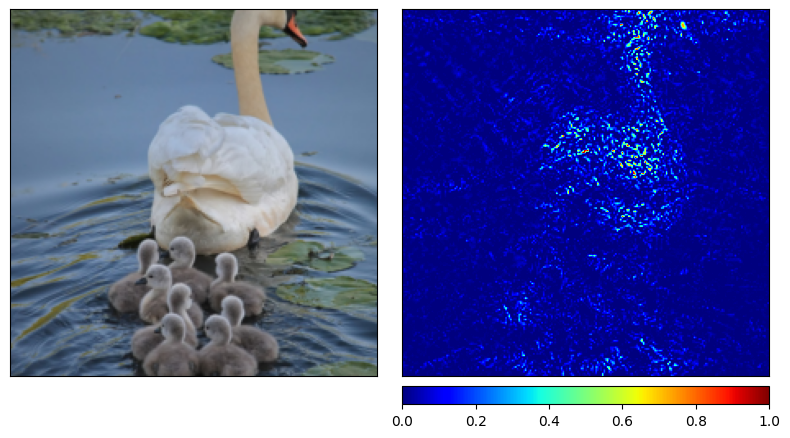

In [ ]:
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

# _ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
#                              np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
#                              method='heat_map',
#                              cmap=default_cmap,
#                              show_colorbar=True,
#                              sign='positive',
#                              outlier_perc=1)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      methods=["original_image", "heat_map"],
                                      signs=["all", "positive"],
                                      cmap='jet',
                                      show_colorbar=True,
                                      outlier_perc=1)

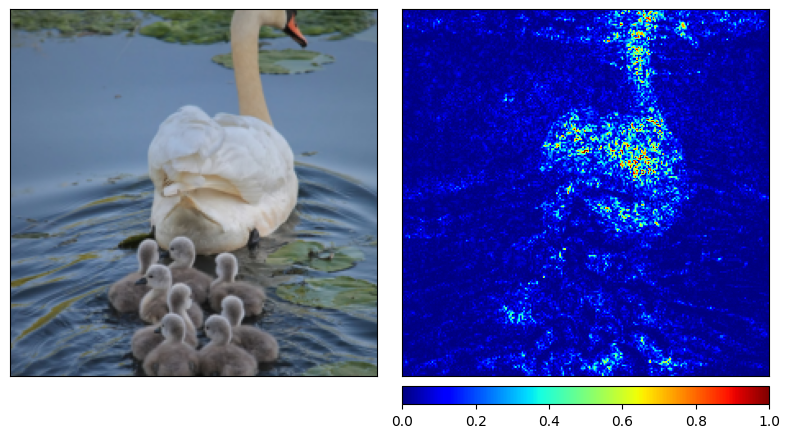

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap='jet',
                                      show_colorbar=True)

In [ ]:
saliency = Saliency(model)
input.requires_grad=True
attributions_s = saliency.attribute(input, target=pred_label_idx)
input.requires_grad=False

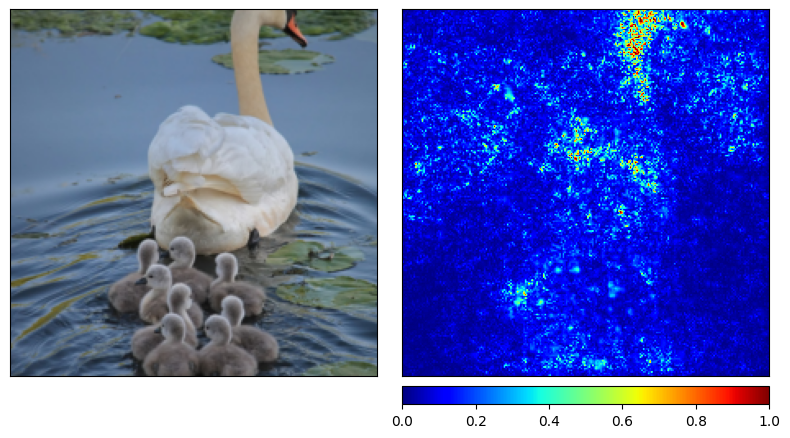

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_s.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap='jet',
                                      show_colorbar=True)

In [ ]:
for name, module in model.named_modules():
    print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer4
layer4.0
layer4.0.conv1
layer4.0.bn1
layer4.0.relu
layer4.0.conv2
layer4.0.bn2
layer4.0.downsample
layer4.0.downsample.0
layer4.0.downsample.1
layer4.1
layer4.1.conv1
layer4.1.bn1
layer4.1.relu
layer4.1.conv2
layer4.1.bn2
avgpool
fc


In [ ]:
layer_gc = LayerGradCam(model, model.layer4[1].conv2)
attributions_lgc = layer_gc.attribute(input, pred_label_idx)

In [ ]:
print(attributions_s.shape) #expected size
print(attributions_lgc.shape)

from captum.attr._utils.attribution import  LayerAttribution
#https://captum.ai/api/base_classes.html
gradcam_maps = LayerAttribution.interpolate(attributions_lgc, input.shape[2:4], interpolate_mode='bicubic')

print(gradcam_maps.shape)

gradcam_maps = gradcam_maps * torch.ones(3, dtype=int)[:, None, None]

print(gradcam_maps.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 7, 7])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


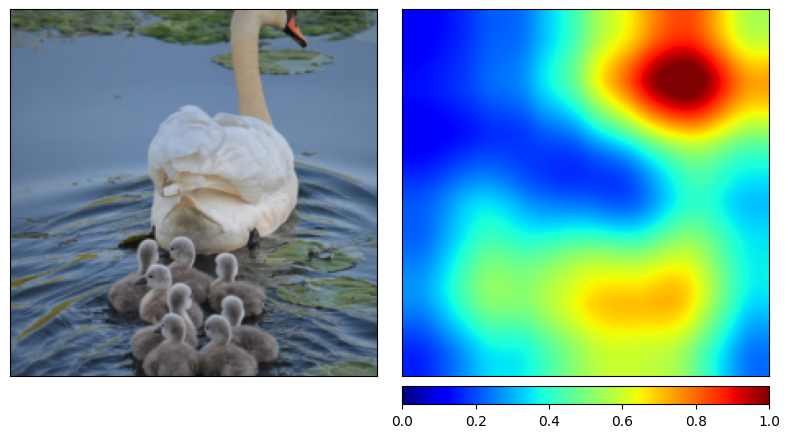

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(gradcam_maps.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap='jet',
                                      show_colorbar=True)

In [ ]:
from captum._utils.models.linear_model import SkLearnLinearRegression
from captum.attr._core.lime import get_exp_kernel_similarity_function

exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)

lr_lime = Lime(
    model,
    interpretable_model=SkLearnLinearRegression(),  # build-in wrapped sklearn Linear Regression
    similarity_func=exp_eucl_distance
)

attrs_lime = lr_lime.attribute(
    input,
    target=pred_label_idx,
    n_samples=40,
    perturbations_per_eval=16,
    show_progress=True
).squeeze(0)

print('Attribution range:', attrs_lime.min().item(), 'to', attrs_lime.max().item())

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1095: UserWarning: Attempting to construct interpretable model with > 10000 features.This can be very slow or lead to OOM issues. Please provide a featuremask which groups input features to reduce the number of interpretablefeatures. 
  warnings.warn(


Lime attribution:   0%|          | 0/3 [00:00<?, ?it/s]

Attribution range: -0.00047779740998521447 to 0.00029307574732229114


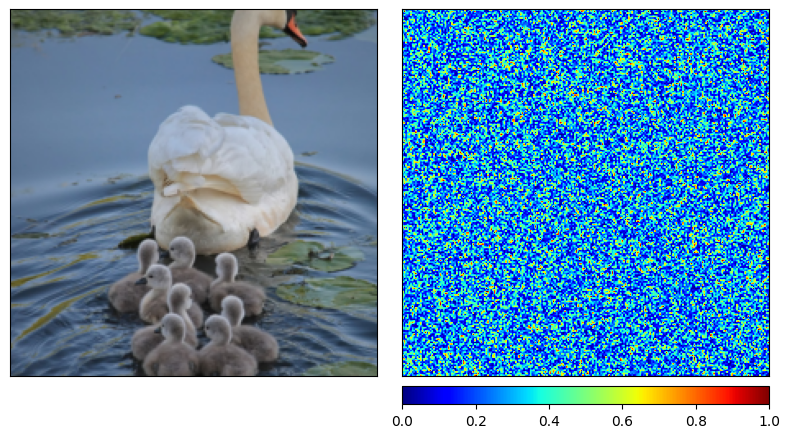

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attrs_lime.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap='jet',
                                      show_colorbar=True)

## Occlusion-based attribution

In [ ]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8), #(3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15), #(3,60, 60),
                                       baselines=0)

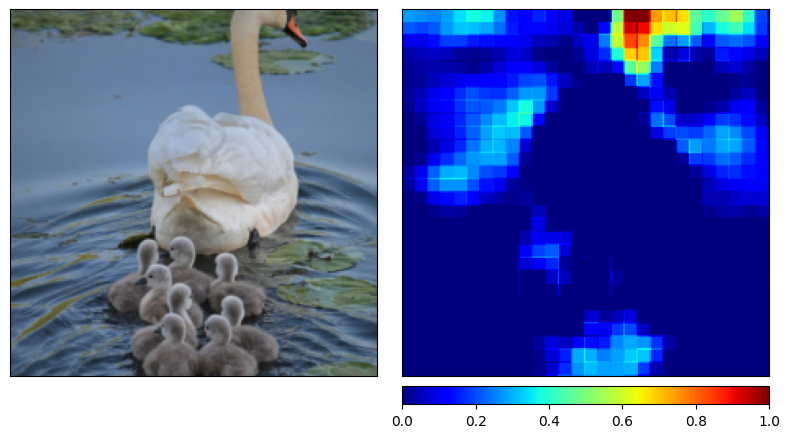

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap='jet',
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

In [ ]:
%%capture
!pip install captum-rise

In [ ]:
from rise import RISE

rise = RISE(model)

n_masks=2**12
initial_mask_shape=(8,8)
heatmap_rise = rise.attribute(input, n_masks=n_masks, initial_mask_shapes=(initial_mask_shape,), target=pred_label_idx, show_progress=True)

R I S E mask:   0%|          | 0/4096 [00:00<?, ?it/s]

In [ ]:
heatmap_rise_adapted = heatmap_rise.unsqueeze(0) * torch.ones(3, dtype=int)[:, None, None]
heatmap_rise_adapted -= heatmap_rise_adapted.min()
heatmap_rise_adapted /= heatmap_rise_adapted.max()
heatmap_rise_adapted.shape, heatmap_rise_adapted.min(), heatmap_rise_adapted.max()

(torch.Size([1, 3, 224, 224]), tensor(0.), tensor(1.))

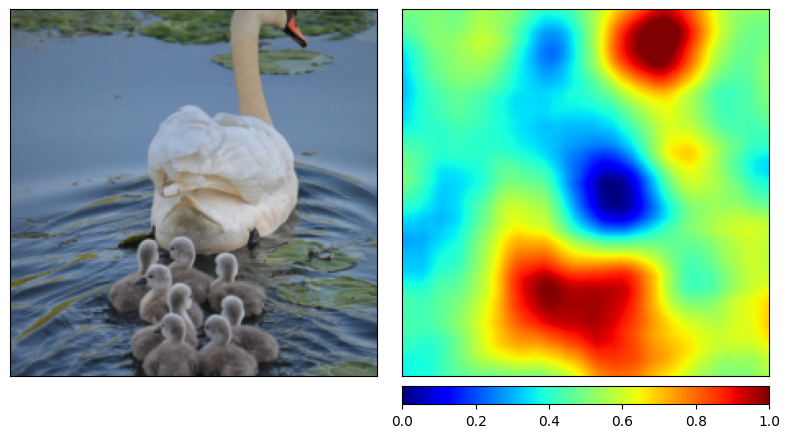

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(heatmap_rise_adapted.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap='jet',
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )